<center><img src="img/logo_hse.png" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 1: Генеративные сети</center></h2>

# Введение

Не все же нам MNIST генерировать. Давайте посмотрим, как генеративные модели могут использоваться не только для развлечения. Поехали!

Немного вступления и мотивации, для чего мы хотим обучать модель.

## MAGIC – Major Atmospheric Gamma Imaging Cherenkov Telescope

MAGIC (Major Atmospheric Gamma Imaging Cherenkov) - это система, состоящая из двух черенковских телескопов диаметром 17 м. Они предназначены для наблюдения гамма-лучей от галактических и внегалактических источников в диапазоне очень высоких энергий (от 30 ГэВ до 100 ТэВ). 

MAGIC позволил открыть и исследовать новые классы источников гамма-излучения, таких как, например, пульсары и гамма-всплески (GRB).

<center><img src="img/magic1.jpg" width="1000"></center>

Источник: https://magic.mpp.mpg.de/

Youtube video: https://youtu.be/mjcDSR2vSU8

#### Ок, давайте зафиксируем. Какой-то крутой телескоп позволяет открыть новые виды излучения. Идем дальше.

## Частицы из космоса

Космические частицы, $\gamma$-кванты (фотоны) и адроны (протоны), взаимодействуют с атмосферой и порождают ливни вторичных частиц. Двигаясь с околосветовой скоростью, эти частицы излучают Черенковское излучение. Телескопы фотографируют это излучение. 
#### По фотографиям можно определить тип частицы из космоса: фотон или протон. Знакомая формулировка задачи, не правда ли?

<center><img src="img/shower.jpg" width="500"></center>

## Фотографии

Задача атмосферного черенковского телескопа - получить изображение ливня путем измерения черенковского света от частиц ливня. Это изображение представляет собой геометрическую проекцию ливня на детектор. Для анализа этих изображений были введены параметры изображения или так называемые параметры Хилласа. Ниже пример такой фотографии.

<center><img src="img/geo.jpg" width="400"></center>

#### Итак, каждая фотография описывается набором параметров, которые за нас считает телесоп. А что там с двумя видами частиц?

## Фотоны vs адронов

Изображения для $\gamma$-квантов (фотонов) и адронов (протонов) отличаются по форме кластеров. Астрономы используют модели машинного обучения для классификации этих изображений. Получение каждого такого изображения - дорогое удовольствие!


<center><img src="img/gamma_p.png" width="600"></center>

Для обучения моделей ученые искусственно генерируют такие изображения для каждого типа частиц с помощью сложных физических симуляторов. 

#### Итак, давайте сэкономим денег для ученых и сгенерируем хороших фотографий разных частиц. Используем для этого GAN и диффузионные модели!

In [190]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Данные

Будем использовать данные телескопа MAGIC из UCI репозитория https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope. Каждый объект в данных - параметры одного изображения кластера и метка этого кластера (фотон или адрон):


0. Length: major axis of ellipse [mm]
1. Width: minor axis of ellipse [mm]
2. Size: 10-log of sum of content of all pixels [in #phot]
3. Conc: ratio of sum of two highest pixels over fSize [ratio]
4. Conc1: ratio of highest pixel over fSize [ratio]
5. Asym: distance from highest pixel to center, projected onto major axis [mm]
6. M3Long: 3rd root of third moment along major axis [mm]
7. M3Trans: 3rd root of third moment along minor axis [mm]
8. Alpha: angle of major axis with vector to origin [deg]
9. Dist: distance from origin to center of ellipse [mm]
10. class: g,h # gamma (signal), hadron (background)

In [191]:
# read data
names = np.array(
    [
        "Length",
        "Width",
        "Size",
        "Conc",
        "Conc1",
        "Asym",
        "M3Long",
        "M3Trans",
        "Alpha",
        "Dist",
        "class",
    ]
)
data = pd.read_csv("/kaggle/input/telescope/magic04.data", header=None)
data.columns = names
print(data.shape)
data.head()

(19020, 11)


,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


# Постановка задачи

Ваша задача заключается в том, чтобы с помощью генеративно-состязательных сетей научиться генерировать параметры кластеров на изображениях телескопа для каждого типа частиц (фотона или адрона):

- $X$ - матрица реальных объектов, которые нужно начиться генерировать;
- $y$ - метки классов, которые будем использовать как условие при генерации.

In [192]:
# параметры кластеров на изображениях
X = data[names[:-1]].values
X = np.abs(X)

# метки классов
labels = data[names[-1]].values
y = np.ones((len(labels), 1))
y[labels == "h"] = 0

In [193]:
# примеры
X[:2]

array([[2.87967e+01, 1.60021e+01, 2.64490e+00, 3.91800e-01, 1.98200e-01,
        2.77004e+01, 2.20110e+01, 8.20270e+00, 4.00920e+01, 8.18828e+01],
       [3.16036e+01, 1.17235e+01, 2.51850e+00, 5.30300e-01, 3.77300e-01,
        2.62722e+01, 2.38238e+01, 9.95740e+00, 6.36090e+00, 2.05261e+02]])

In [194]:
# примеры
y[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [195]:
# все возможные значения
np.unique(y)

array([0., 1.])

# Визуализация данных

Каждое изображение описывается 10 параметрами. Давайте построим распределения значений каждого параметра для каждого типа частиц.

In [196]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(5 * 4, 5 * 2))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i + 1)
        plt.grid()
        plt.hist(X1[:, i], bins=bins, alpha=0.3, label=label1, color="C4")
        plt.hist(X2[:, i], bins=bins, alpha=0.3, label=label2, color="C0")
        plt.xlabel(names[i], size=14)
        plt.legend(loc="best")
    plt.tight_layout()

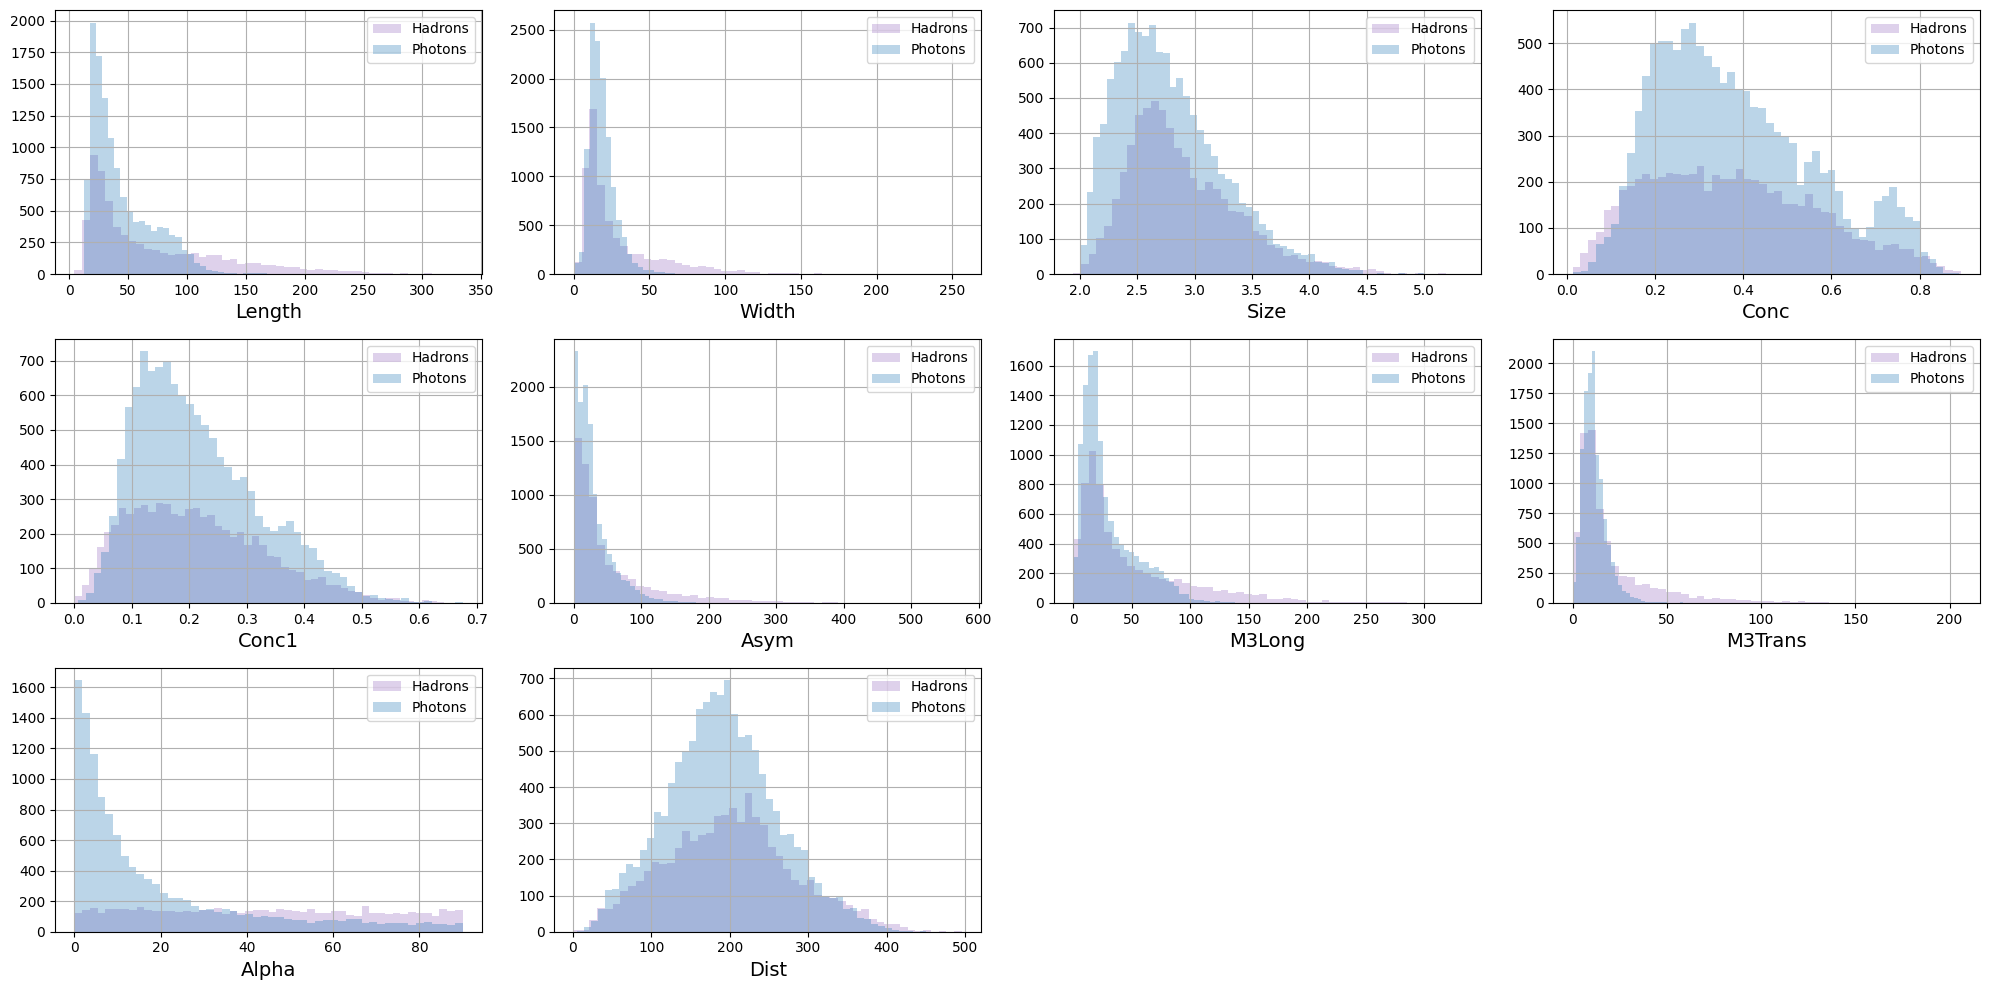

In [197]:
plot_hists(
    X[y[:, 0] == 0], X[y[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

# Предобработка данных

Из графика видим, что распределения для многих признаков имеют тяжелые хвосты. Это делает обучение генеративных моделей тяжелее. Поэтому нужно как-то преобразовать данные, чтобы убрать эти тяжелые хвосты.

# Обучающая и тестовая выборки

In [198]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.5, shuffle=True, random_state=11
)

## Задание 1 (0.2 балла)

Проиллюстрируйте распределение y внутри train и test выборки.

Train


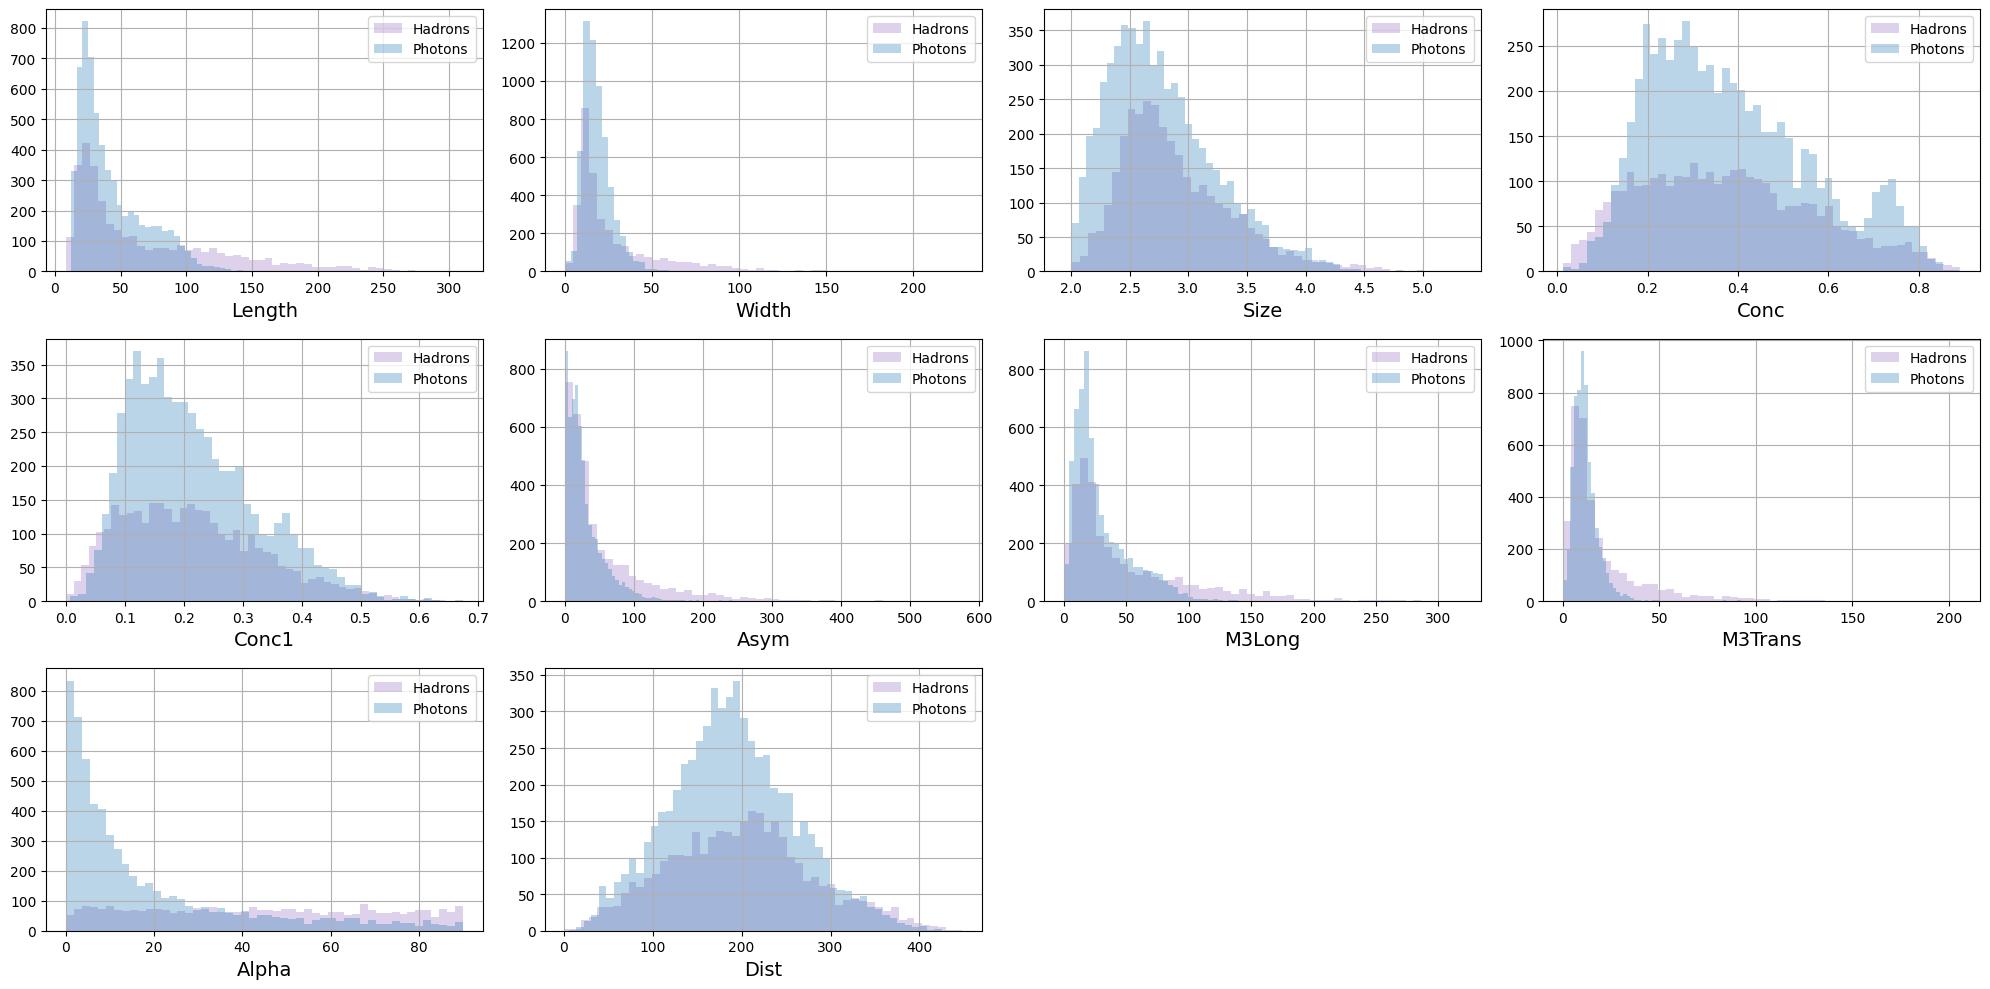

In [199]:
print('Train')
plot_hists(
    X_train[y_train[:, 0] == 0], X_train[y_train[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

Test


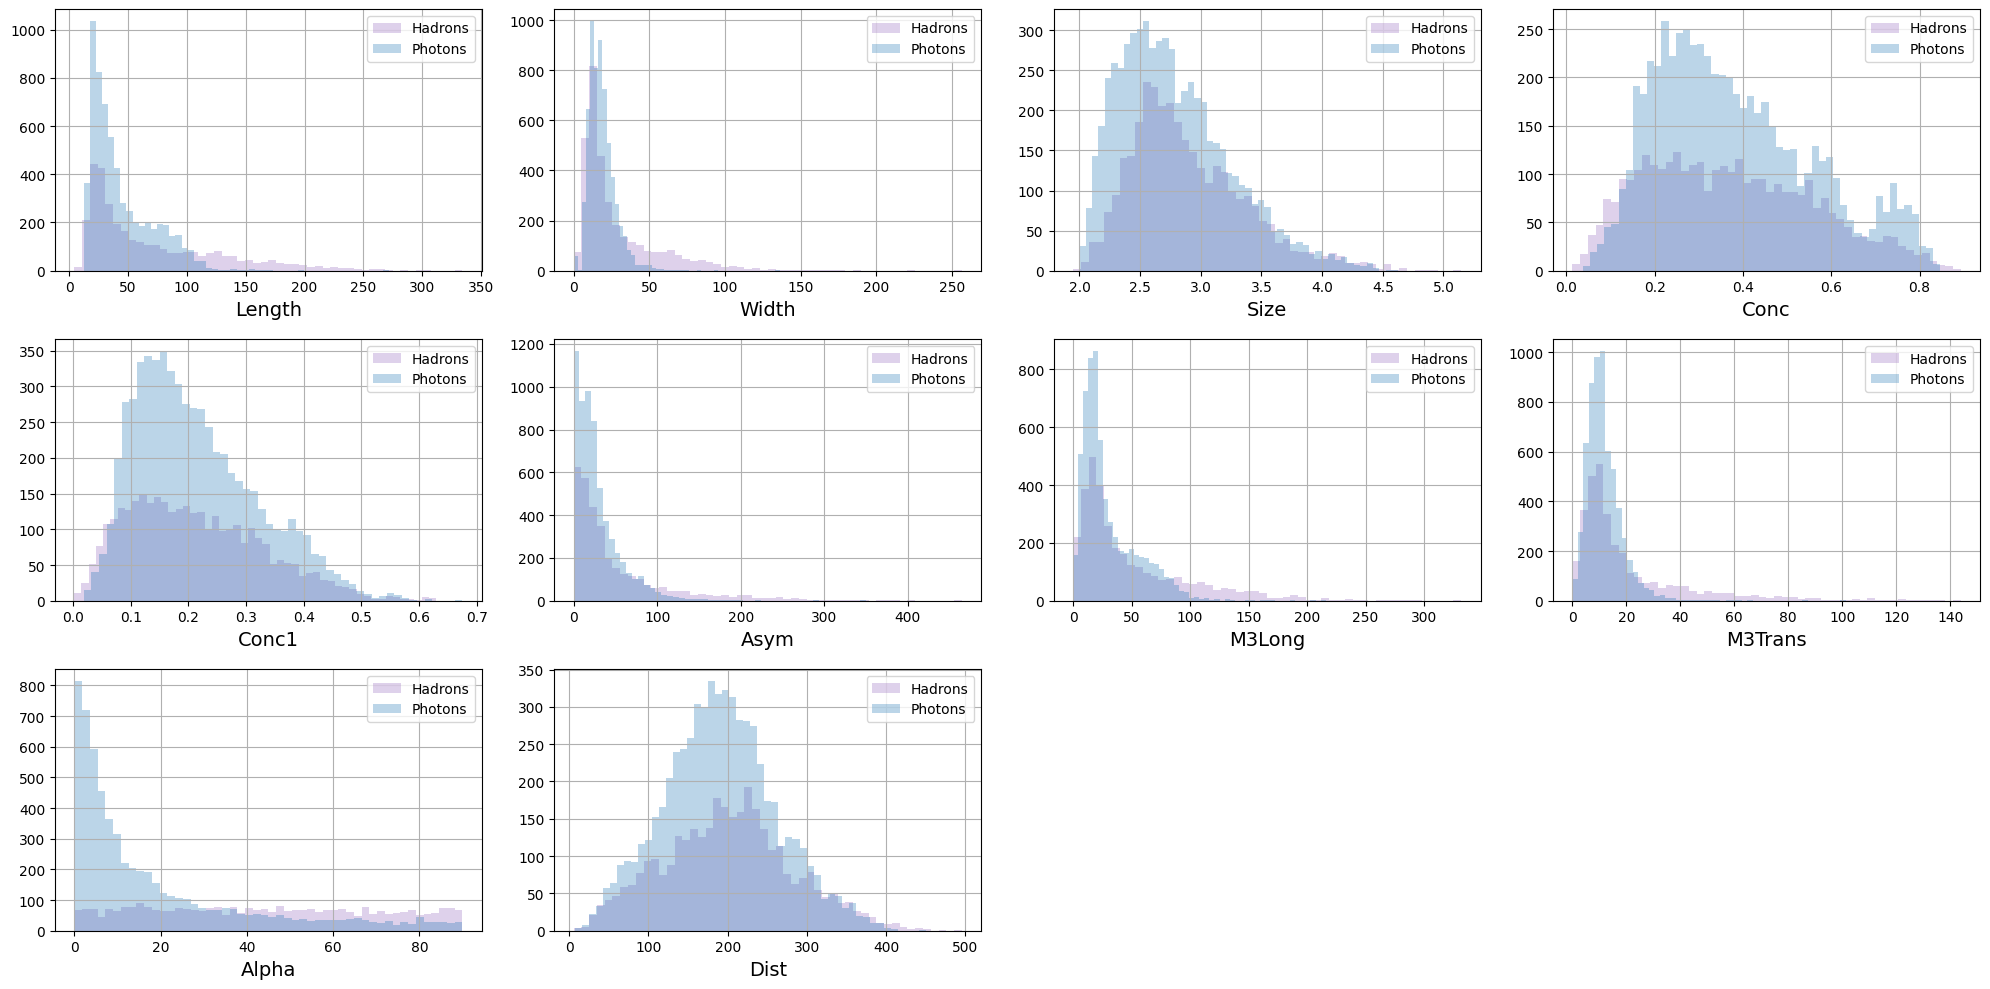

In [200]:
print('Test')
plot_hists(
    X_test[y_test[:, 0] == 0], X_test[y_test[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

## Задание 2 (0.8 балл)

Используя функцию `sklearn.preprocessing.QuantileTransformer` трансформируйте входные данные `X_train` и `X_test`. Это преобразование делает так, чтобы распределение каждого параметра было нормальным. Описание функции доступно по [ссылке](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html). Используйте значение параметра `output_distribution='normal'`.

In [201]:
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer(n_quantiles=1000, output_distribution='normal')
X_train = qt.fit_transform(X_train)
X_test = qt.transform(X_test)

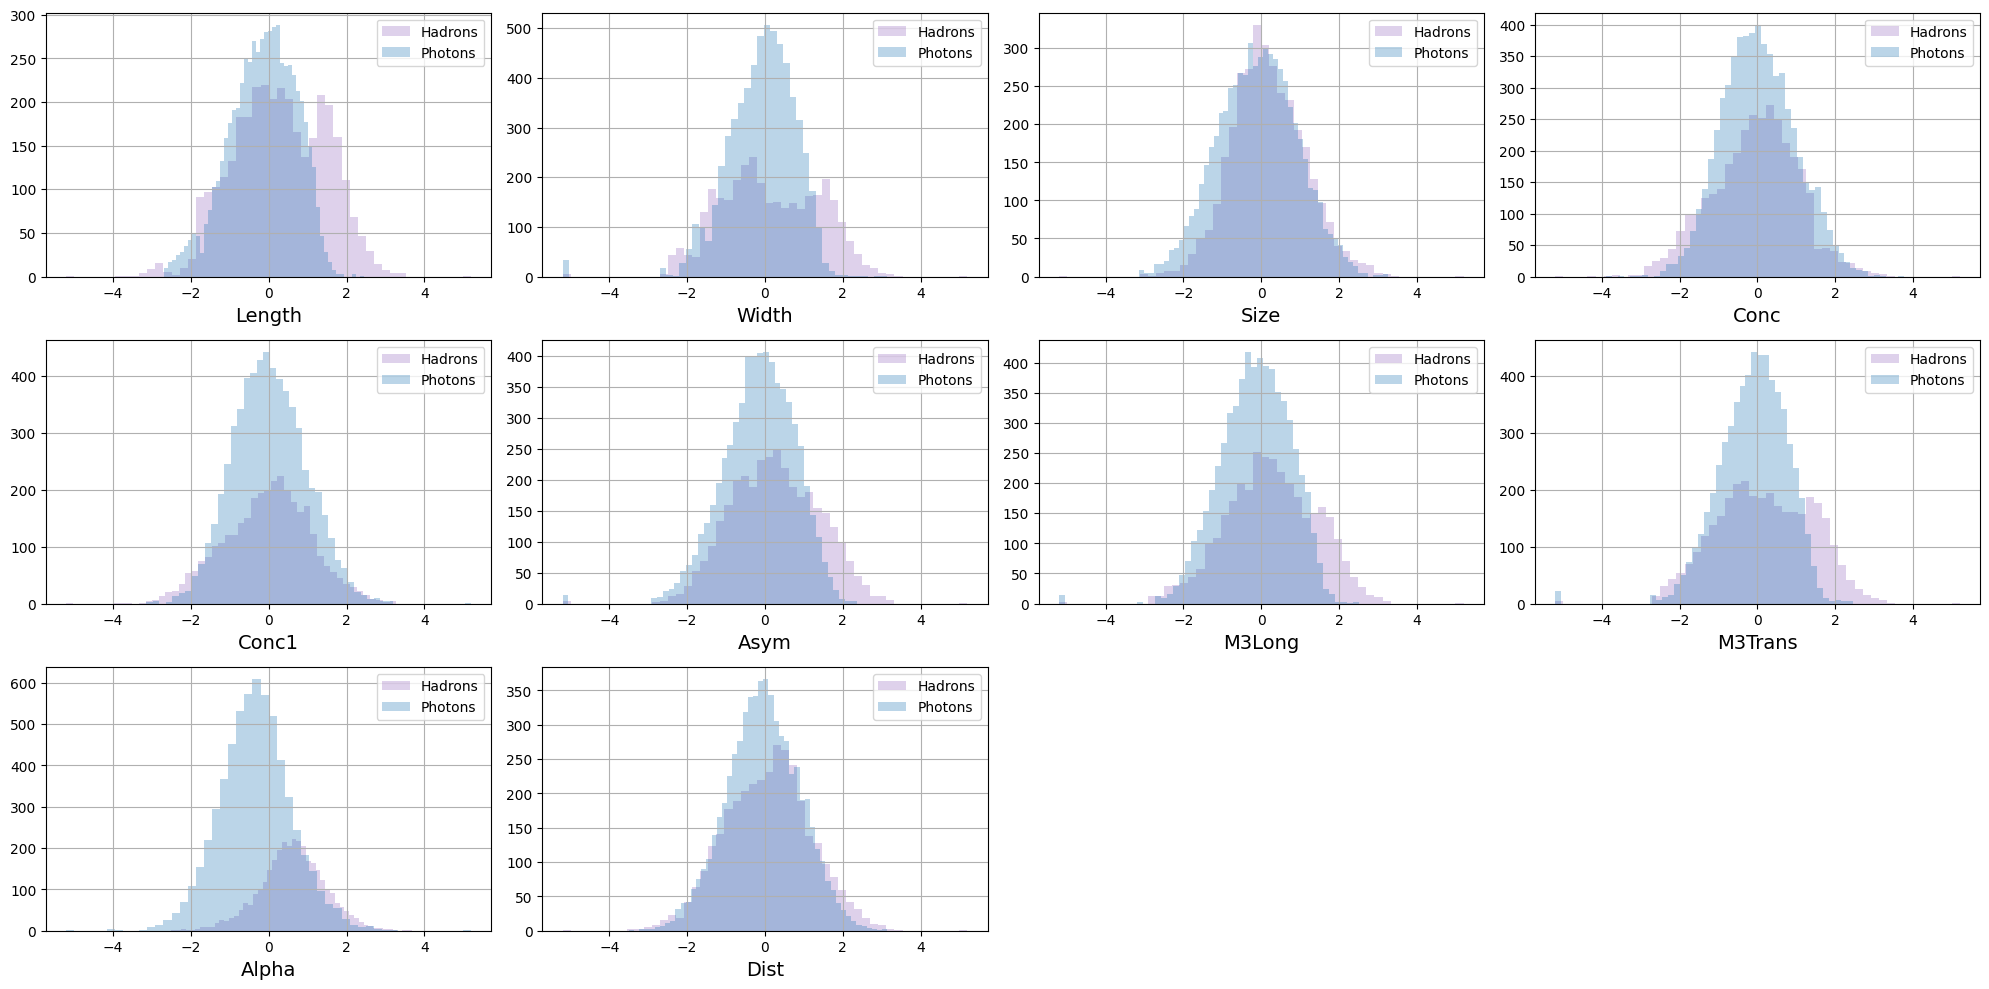

In [202]:
plot_hists(
    X_train[y_train[:, 0] == 0],
    X_train[y_train[:, 0] == 1],
    names,
    label1="Hadrons",
    label2="Photons",
    bins=50,
)

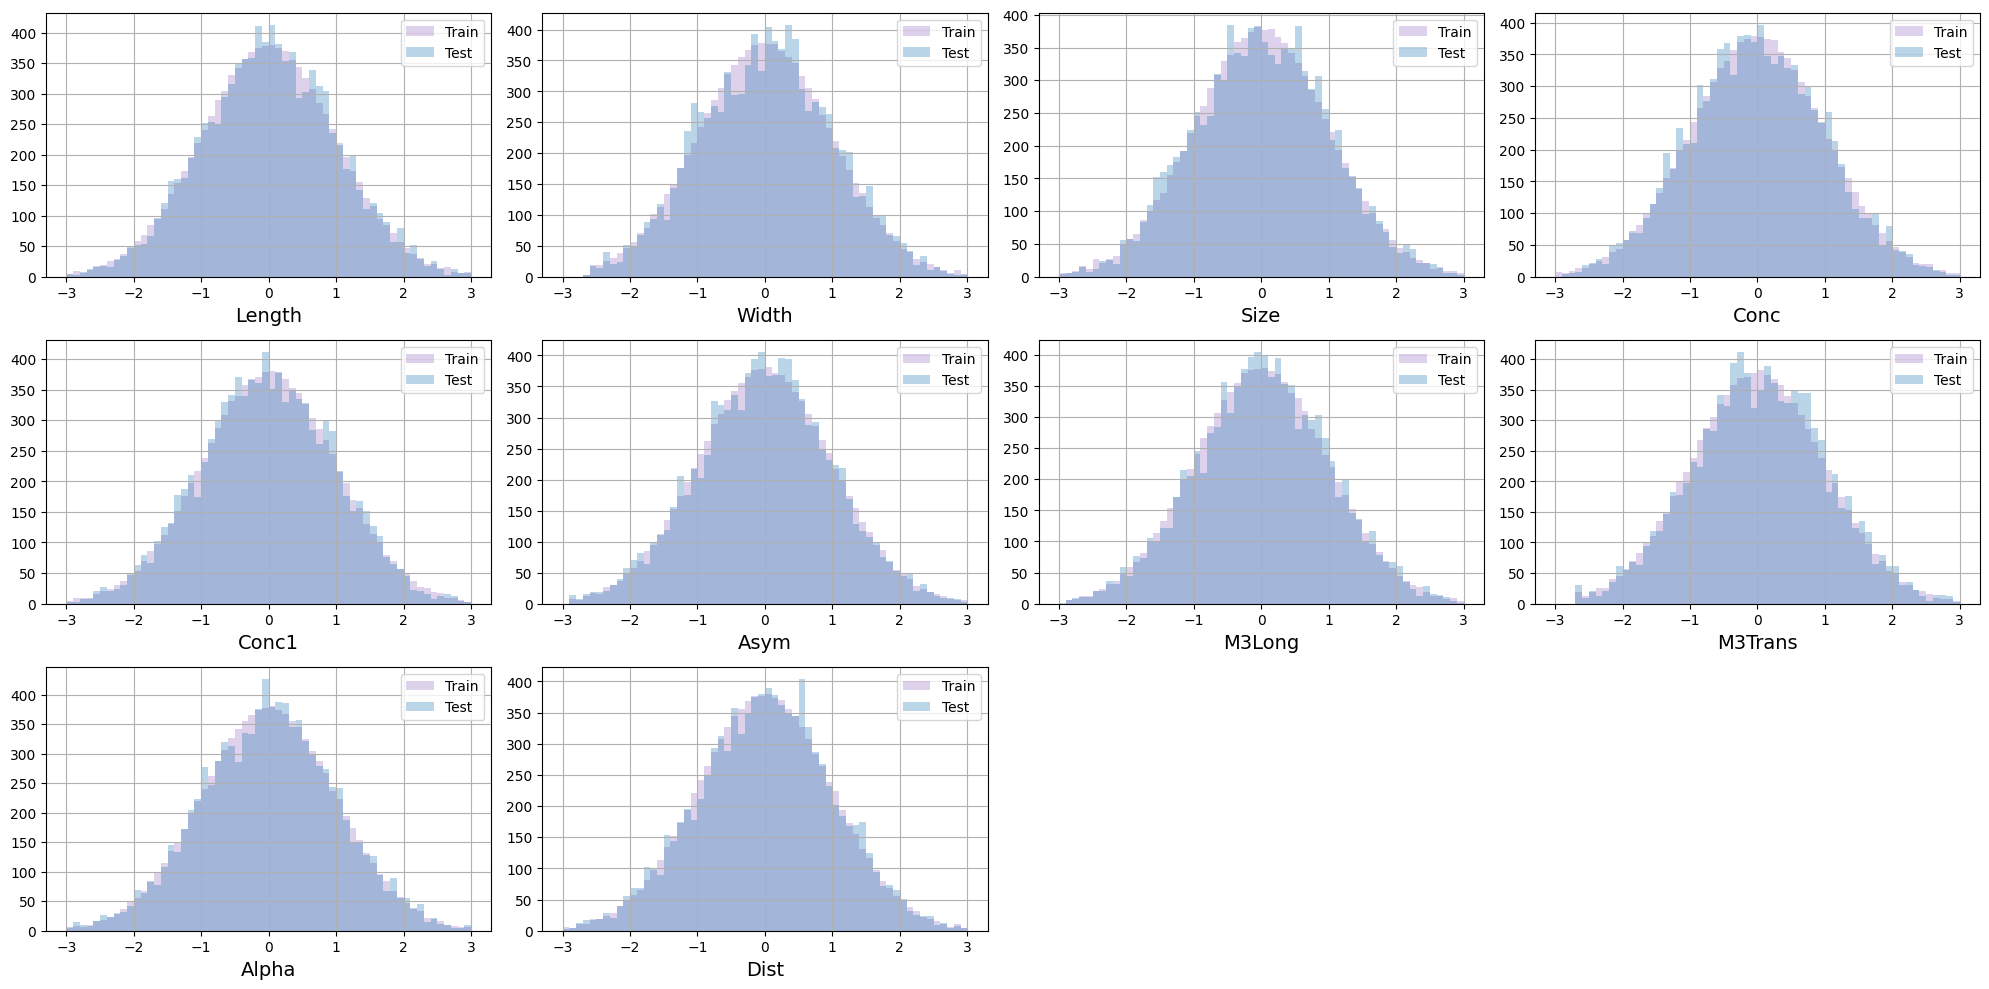

In [203]:
plot_hists(X_train, X_test, names, label1="Train", label2="Test")

# Conditional WGAN

Мы будем использовать `Conditional WGAN`, который изображен на рисунке. В качестве условия `y` мы будем использовать метку класса: **0** - адрон, **1** - фотон. Таким образом, мы будем сообщать генератору для какой частицы нужно генерировать параметры изображения. 

<center><img src="img/cgan.png" width="800"></center>

Генератор $\hat{x} = G(z, y)$ будет принимать на вход шумовой вектор $z$ и вектор условий $y$, а выдавать будет сгенерированный (фейковый) вектор параметров $\hat{x}$. 

Дискриминатор $D(x, y)$ будет принимать на вход вектор параметров $x$ и вектор условий $y$, а возвращать будет рациональное число.

Обучать `Conditional WGAN` будем с такой функцией потерь:

$$L(G, D) = -\frac{1}{n} \sum_{x_i \in X, y_i \in y} D(x_i, y_i) + -\frac{1}{n} \sum_{z_i \in Z, y_i \in y} D(G(z_i, y_i), y_i) \to \max_G \min_D$$

In [204]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [205]:
DEVICE

device(type='cpu')

## Задание 3 (0.75 балла)

Реализуйте нейронную сеть для генератора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [206]:
class Generator(nn.Module):
    def __init__(self, n_inputs, n_outputs, latent_dim = 100):
        super(Generator, self).__init__()

        ### YOUR CODE IS HERE ######
        self.model = nn.Sequential(
            nn.Linear(n_inputs, latent_dim),
            nn.BatchNorm1d(latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, latent_dim),
            nn.BatchNorm1d(latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, n_outputs)
        ) 
        ### THE END OF YOUR CODE ###

    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        return self.model(zy)

## Задание 4 (0.5 балл)

Реализуйте функцию для генерации новый объектов $X$ по вектору условий $y$.

In [207]:
def generate(generator, y, latent_dim):
    ### YOUR CODE IS HERE ######
    y = torch.tensor(y, dtype=torch.float, device=DEVICE)
    generator = generator.to(DEVICE)
    Z_noise = torch.normal(0, 1, (len(y), latent_dim)).to(DEVICE)
    X_fake = generator(Z_noise, y)
    ### THE END OF YOUR CODE ###
    return X_fake.cpu().detach().numpy()  # numpy

## Задание 5 (0.75 балла)

Реализуйте нейронную сеть для дискриминатора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Выходной слой.

Какая функция активации должна быть в конце работы модели и почему? А она вообще тут должна быть? Обоснуйте свой выбор.


Ответ: В конце модели можно не ставить никакую функцию, можно ставить сигмоиду, по сути особой разницы нет. Ведь мы просто будем учить так, чтобы дискриминатор пытался увеличить это значение на реальных объекта и уменьшить на фейковых.

In [208]:
class Discriminator(nn.Module):
    def __init__(self, n_inputs, latent_dim = 20):
        super(Discriminator, self).__init__()

        ### YOUR CODE IS HERE ######
        self.model = nn.Sequential(
            nn.Linear(n_inputs, latent_dim),
            nn.BatchNorm1d(latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, latent_dim),
            nn.BatchNorm1d(latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, 1),
          #  nn.Sigmoid()
        ) 
        ### THE END OF YOUR CODE ###

    def forward(self, x, y):
        xy = torch.cat((x, y), dim=1)
        return self.model(xy)

## Задание 6 (0.5 балла)

Реализуйте функцию, которая принимала бы на вход набор сгенерированных и настоящих объектов, разбивала на train и test с учетом баланса классов (real и fake объектов), с соотношением 3 к 1, обучала модель логистической регрессии и градиентного бустинга, которые учились бы отличать настоящие объекты от фальшивых, после чего выводила бы accuracy score на отложенной выборке у обоих моделей.

Ответьте на вопрос: какое значение accuracy score нас бы удовлетворило больше всего? Почему?


В идеале accuracy должно быть равно числу объектов наибольшего классу fake или real. То есть fake настолько похож на real что модель ничего ничего не выучила и просто возвращает то, чего больше.

In [209]:
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

In [210]:
def other_agent_score(X_real, y_real, X_fake, y_fake):
    ### YOUR CODE IS HERE ######
    X_real = np.array(X_real)
    y_real = np.array(y_real)
    X_fake = np.array(X_fake)
    y_fake = np.array(y_fake)
    # создаем train и test
    data_real = np.concatenate((X_real, y_real[:, None]), axis=1)
    data_fake = np.concatenate((X_fake, y_fake[:, None]), axis=1)
    combined_array = np.vstack((data_real, data_fake))
    labels = np.hstack((np.ones(data_real.shape[0]), np.zeros(data_fake.shape[0])))
    X_train, X_test, y_train, y_test = train_test_split(
    combined_array, labels, stratify=labels, test_size=0.25, shuffle=True, random_state=11
)
    
    # log reg
    logistic_reg = LogisticRegression()
    logistic_reg.fit(X_train, y_train)
    y_pred = logistic_reg.predict(X_test)
    lin_reg_score = accuracy_score(y_test, y_pred)
    
    # boosting
    boosting = CatBoostClassifier(iterations=10,verbose=False)
    boosting.fit(X_train, y_train)
    y_pred = boosting.predict(X_test)
    boosting_score = accuracy_score(y_test, y_pred)
    ### THE END OF YOUR CODE ###
    print("Linear regression score: " + str(lin_reg_score))
    print("Boosting score: " + str(boosting_score))

## Задание 7 (1.5 балла)

Реализуйте класс для обучения генеративной модели.

- Уточнение 1: Нужно ограничивать веса дискриминатора. Для этого используйте `p.data.clamp_(-0.01, 0.01)`, где `p` веса дискриминатора. Зачем это делать можно посмотреть в оригинальной статье <https://arxiv.org/pdf/1701.07875.pdf>.
- Подсказка 1: `n_critic` - число итераций обучения дискриминатора на одну итерацию обучения генератора.
- Подсказка 2: Используйте `X_tensor = torch.tensor(X_numpy, dtype=torch.float, device=DEVICE)` для перевода numpy в тензор.

In [211]:
class Fitter(object):
    def __init__(
        self,
        generator,
        discriminator,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr_d=0.0001,
        lr_g=0.005,
        n_critic=5,
    ):
        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.n_critic = n_critic
        
        self.lr_d = lr_d
        self.lr_g=lr_g

        self.opt_gen = torch.optim.RMSprop(self.generator.parameters(), lr=self.lr_g)
        self.opt_disc = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.lr_d)

        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.generator.train(True)
        self.discriminator.train(True)

        self.loss_history = []

        # Fit GAN
        for epoch in range(self.n_epochs):
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                ### YOUR CODE IS HERE ######
                real_batch = real_batch.to(DEVICE)
                cond_batch = cond_batch.to(DEVICE)
                # учим дискриминатор
                if i % (self.n_critic + 1) != 0:
                    self.opt_disc.zero_grad()

                    Z_noise = torch.normal(0, 1, (len(real_batch), self.latent_dim)).to(DEVICE)
                    X_fake = self.generator(Z_noise, cond_batch)
                    loss_epoch = -(torch.mean(self.discriminator(real_batch, cond_batch)) - torch.mean(
                        self.discriminator(X_fake, cond_batch)))
                    loss_epoch.backward()
                    self.opt_disc.step()
                    for p in self.discriminator.parameters():
                        p.data.clamp_(-0.01, 0.01)
                # учим генератор
                else:
                    self.opt_gen.zero_grad()

                    Z_noise = torch.normal(0, 1, (len(real_batch), self.latent_dim)).to(DEVICE)
                    X_fake = self.generator(Z_noise, cond_batch)
                    loss_epoch = torch.mean(self.discriminator(real_batch, cond_batch)) - torch.mean(
                        self.discriminator(X_fake, cond_batch)
                    )
                    loss_epoch.backward()
                    self.opt_gen.step()

                ### THE END OF YOUR CODE ###

            # caiculate and store loss after an epoch
            with torch.no_grad():
                Z_noise = torch.normal(0, 1, (len(X_real), self.latent_dim)).to(DEVICE)
                X_fake = self.generator(Z_noise, y_cond)
                loss_epoch = torch.mean(self.discriminator(X_real, y_cond)) - torch.mean(
                    self.discriminator(X_fake, y_cond)
                )
                self.loss_history.append(loss_epoch.detach().cpu())

            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов
            # И запустите работу фукнции other_agent_score

            ### YOUR CODE IS HERE ######
            if epoch % 10 == 0:
                with torch.no_grad():
                    Z_noise = torch.normal(0, 1, (1000, self.latent_dim)).to(DEVICE)
                    indices = torch.randperm(X_real.shape[0])[:1000]
                    x_subsample_real = X_real[indices]
                    y_subsample = y_cond[indices]
                    X_fake = self.generator(Z_noise, y_subsample)

                    x_subsample_real = x_subsample_real.cpu()
                    y_subsample = y_subsample.cpu().flatten()
                    X_fake = X_fake.cpu()
                    other_agent_score(x_subsample_real, y_subsample, X_fake, y_subsample)    
                
            
            ### THE END OF YOUR CODE ###

        # Turn off training
        self.generator.train(False)
        self.discriminator.train(False)

## Обучение
Обучим модель на данных.

In [212]:
%%time
latent_dim = 10
generator = Generator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1], latent_dim=1000)
discriminator = Discriminator(n_inputs=X_train.shape[1] + y.shape[1], latent_dim=50)

fitter = Fitter(
    generator,
    discriminator,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    n_critic=10,
    lr_d=0.0001,
    lr_g=0.0001,
)
fitter.fit(X_train, y_train)

Linear regression score: 0.686
Boosting score: 0.91
Linear regression score: 0.72
Boosting score: 0.78
Linear regression score: 0.728
Boosting score: 0.73
Linear regression score: 0.708
Boosting score: 0.712
Linear regression score: 0.74
Boosting score: 0.674
Linear regression score: 0.692
Boosting score: 0.67
Linear regression score: 0.69
Boosting score: 0.67
Linear regression score: 0.674
Boosting score: 0.676
Linear regression score: 0.646
Boosting score: 0.654
Linear regression score: 0.678
Boosting score: 0.71
CPU times: user 5min 37s, sys: 17.6 s, total: 5min 55s
Wall time: 2min 56s


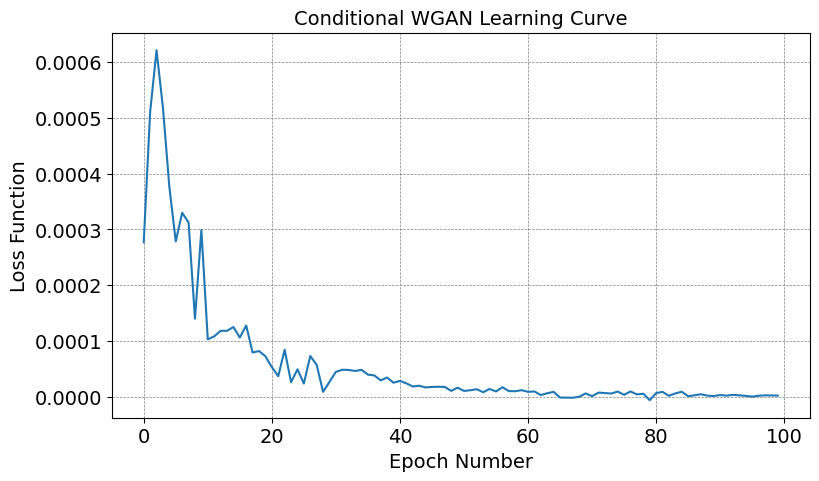

In [213]:
# WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional WGAN Learning Curve", size=14)
plt.grid(linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 8 (0.5 балла)

Теперь сгенерируем фейковые матрицы `X_fake_train` и `X_fake_test`. Сравним их с матрицами реальных объектов `X_train` и `X_test`. Перед сравнением результатов сделайте обратное квантильное преобразование с помощью трансформера, который вы обучили в задании 2.

In [214]:
X_train_inv = qt.inverse_transform(X_train)
X_test_inv = qt.inverse_transform(X_test)

In [215]:
### YOUR CODE IS HERE ######
X_fake_train = generate(fitter.generator, y_train, latent_dim)
X_fake_train = qt.inverse_transform(X_fake_train)
X_fake_test = generate(fitter.generator, y_test, latent_dim)
X_fake_test = qt.inverse_transform(X_fake_test)
### THE END OF YOUR CODE ###

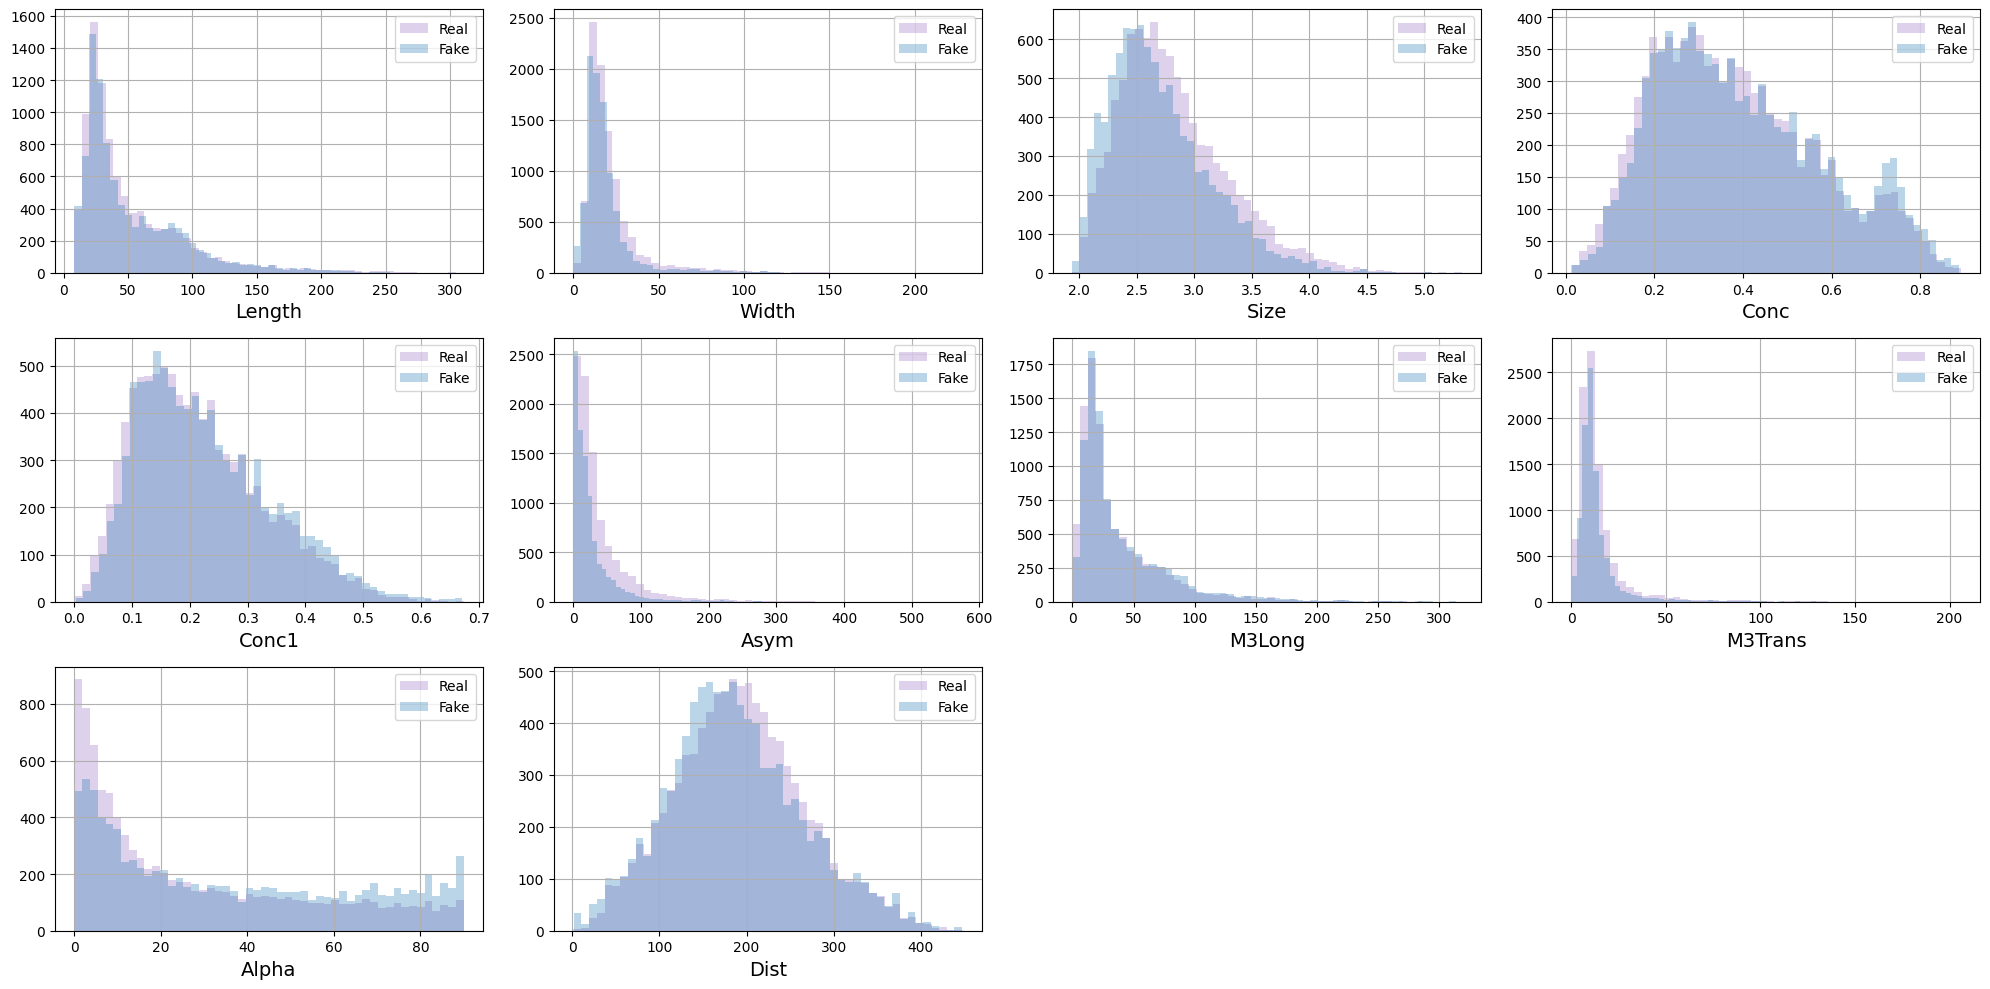

In [216]:
plot_hists(X_train_inv, X_fake_train, names, label1="Real", label2="Fake", bins=50)

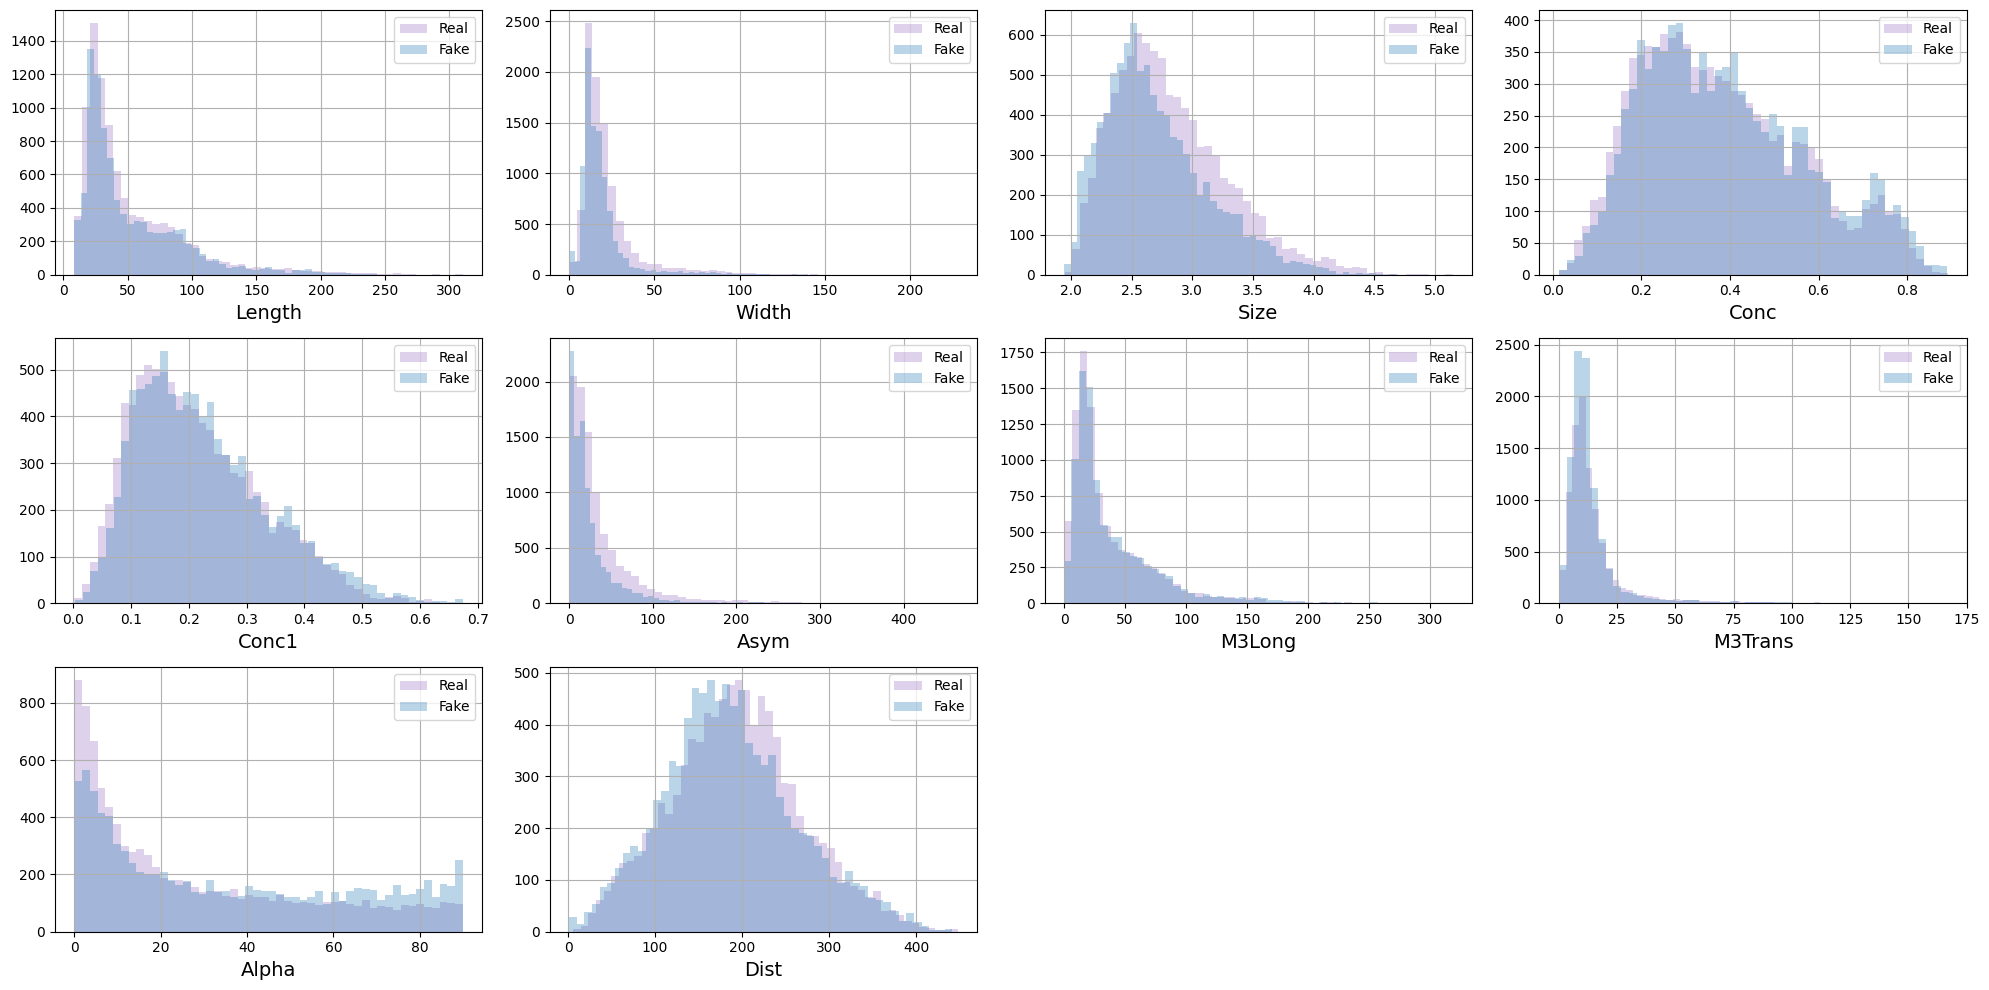

In [217]:
plot_hists(X_test_inv, X_fake_test, names, label1="Real", label2="Fake", bins=50)

## Вывод: 
Визуально мы видим сходство реальных и фейковых данных. Однако это только проекции 10-мерных объектов на одну ось.

# Измерение качества генерации

<center><img src="img/clf.png" width="600"></center>

Измерим сходство распределений классификатором.

In [218]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train_inv), axis=0)
XX_test = np.concatenate((X_fake_test, X_test_inv), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train_inv))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test_inv))

In [219]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [220]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.8363056210685305


## Задание 9 (0.5 балла)

Опишите ваш эксперимент. Как вы оцениваете полученные результаты? Как вы думаете, какое значение ROC AUC нас удовлетворяет больше всего? Почему?


Эксперимент заключался в том, чтобы сгенерировать искуственные данные максимально похожими на реальные данные. Как видно хороший бустинг с большим кол-вом деревьев все же может отличить искуственные данные от реальных с roc-auc = 0.835. В идеале хотелось бы видеть roc-auc = 0.5, чтобы бустинг вообще никак не мог отличить. Но в целом даже 0.835 это вполне хороший результат. Также по графикам в проекции на одномерные фичи видно, что распределение fake и real очень похожи.

## Диффузионные модели.

Давайте теперь проведем такой же экперимент с простой диффузионной моделью.

## Задание 10 (0.5 балла)

Реализуйте фукнцию из семинара для зашумления данных, адаптировав ее под наш тип данных.

In [18]:
def corrupt(x, amount):
    ### YOUR CODE IS HERE ######
    noise = torch.randn_like(x)
    x = x * (1 - amount) + noise * amount
    ### THE END OF YOUR CODE ###
    return x

## Добавим sсheduler, он пригодится вам при обучении модели

In [18]:
!pip install diffusers -q

In [19]:
from diffusers import DDPMScheduler

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

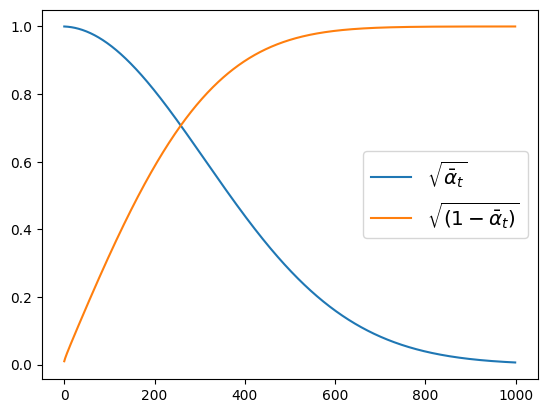

In [20]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.plot(
    noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$"
)
plt.plot(
    (1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5,
    label=r"$\sqrt{(1 - \bar{\alpha}_t)}$",
)
plt.legend(fontsize="x-large")

## Задание 11 (0.5 балла)

Реализуйте нейронную сеть. В качетсве архитектуры можете взять модель генератора. В процессе экспериментов попробуйте изменять архитектуру модели для улучшения качества сгенерированных объектов (Кстати, как вы будете качество измерять?). 

- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [154]:
class DiffusionGenerator(nn.Module):
    def __init__(self, n_inputs, n_outputs, num_train_timesteps, latent_dim=50, class_emb_size=10, timestemp_emb_size=10):
        super(DiffusionGenerator, self).__init__()
        
        ### YOUR CODE IS HERE ######
        num_classes = 2
        self.class_emb = nn.Embedding(num_classes, class_emb_size)
        
        self.timestemp_emb = nn.Embedding(num_train_timesteps, timestemp_emb_size)
        
        self.model_x = nn.Sequential(
            nn.Linear(n_inputs, latent_dim),
            nn.BatchNorm1d(latent_dim),
            nn.ReLU(),
        ) 
        
        self.model = nn.Sequential(
            nn.Linear(latent_dim + class_emb_size + timestemp_emb_size, latent_dim),
            nn.BatchNorm1d(latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, n_outputs),
        ) 
        ### THE END OF YOUR CODE ###

    def forward(self, z, y, t):
        y = self.class_emb(y.flatten())
        t = self.timestemp_emb(t.flatten())
        
        z = self.model_x(z)
        zy = torch.cat((z, y, t), dim=1)
        return self.model(zy)

## Задание 12 (0.5 балла)

Напишите функцию для генерации нового объекта с помощью обученной модели.

In [183]:
def generate_with_diffusion(model, y, latent_dim, sheduler):
    ### YOUR CODE IS HERE ######
    y = torch.tensor(y, dtype=torch.int, device=DEVICE)
    with torch.no_grad():
        Z_noise = torch.randn(y.shape[0], latent_dim).to(DEVICE)

        # find X_fake
        X_fake = Z_noise
        for i, t in enumerate(sheduler.timesteps):
            timesteps = torch.full((y.shape[0], 1), t).to(DEVICE)
            residual = model(X_fake, y, timesteps)
            X_fake = sheduler.step(residual, t, X_fake).prev_sample
        X_fake = X_fake.cpu().numpy()
    ### THE END OF YOUR CODE ###
    return X_fake  # numpy

## Задание 13 (2 балла)

Напишите класс обучения диффузионной модели и обучите модель, после чего опишите полученные результаты. В качестве подсказки - опирайтесь на семинар по диффузионным моделям. Вы можете изменять некоторые части кода для вашего удобства, но оставляйте в таком случаи комментарии, пожалуйста.

In [156]:
class DiffusionFitter(object):
    def __init__(
        self,
        model,
        noise_scheduler,
        num_train_timesteps,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
    ):

        self.model = model
        self.noise_scheduler = noise_scheduler
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.num_train_timesteps = num_train_timesteps

        self.opt_gen = torch.optim.RMSprop(self.model.parameters(), lr=self.lr)
        
        self.loss_fn = nn.MSELoss()

        self.model.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.int, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.model.train(True)

        self.loss_history = []

        for epoch in range(self.n_epochs):
            loss_epoch = 0
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                ### YOUR CODE IS HERE ######
                real_batch = real_batch.to(DEVICE)
                cond_batch = cond_batch.to(DEVICE)
                
                noise = torch.randn_like(real_batch)
                timesteps = torch.randint(0, self.num_train_timesteps-1, (real_batch.shape[0],)).long().to(DEVICE)
                noisy_x = self.noise_scheduler.add_noise(real_batch, noise, timesteps)
                timesteps = timesteps.view(-1, 1)
                
                pred = self.model(noisy_x, cond_batch, timesteps)            
                loss = self.loss_fn(pred, noise)
                self.opt_gen.zero_grad()
                loss.backward()
                self.opt_gen.step()

                loss_epoch += loss.detach().cpu()

                ### THE END OF YOUR CODE ###

            # caiculate and store loss after an epoch

            self.loss_history.append(loss_epoch)

            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов
            # И запустите работу фукнции other_agent_score

            ### YOUR CODE IS HERE ######
            if epoch % 10 == 0:
                num_objects = 1000
                with torch.no_grad():
                    Z_noise = torch.randn(num_objects, self.latent_dim).to(DEVICE)
                    indices = torch.randperm(X_real.shape[0])[:num_objects]
                    x_subsample_real = X_real[indices]
                    y_subsample = y_cond[indices]
                    
                    # find X_fake
                    X_fake = Z_noise
                    for i, t in enumerate(noise_scheduler.timesteps):
                        timesteps = torch.full((num_objects, 1), t).to(DEVICE)
                        residual = self.model(X_fake, y_subsample, timesteps)
                        X_fake = self.noise_scheduler.step(residual, t, X_fake).prev_sample

                    x_subsample_real = x_subsample_real.cpu()
                    y_subsample = y_subsample.cpu().flatten()
                    X_fake = X_fake.cpu()
                    other_agent_score(x_subsample_real, y_subsample, X_fake, y_subsample)  
            ### THE END OF YOUR CODE ###

        # Turn off training
        self.model.train(False)

In [177]:
%%time
latent_dim = 10
num_train_timesteps = 1000
model = DiffusionGenerator(n_inputs=latent_dim, 
                           n_outputs=X_train.shape[1], 
                           latent_dim=15,
                           num_train_timesteps = num_train_timesteps,
                           class_emb_size=5,
                           timestemp_emb_size=10
                           )
noise_scheduler = DDPMScheduler(num_train_timesteps=num_train_timesteps)

diffusionFitter = DiffusionFitter(
    model,
    noise_scheduler,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    num_train_timesteps=num_train_timesteps,
)
diffusionFitter.fit(X_train, y_train)

Linear regression score: 0.722
Boosting score: 0.96
Linear regression score: 0.594
Boosting score: 0.926
Linear regression score: 0.586
Boosting score: 0.89
Linear regression score: 0.692
Boosting score: 0.912
Linear regression score: 0.614
Boosting score: 0.898
Linear regression score: 0.654
Boosting score: 0.888
Linear regression score: 0.608
Boosting score: 0.9
Linear regression score: 0.7
Boosting score: 0.896
Linear regression score: 0.71
Boosting score: 0.926
Linear regression score: 0.718
Boosting score: 0.926
CPU times: user 1min 53s, sys: 3.13 s, total: 1min 56s
Wall time: 57.5 s


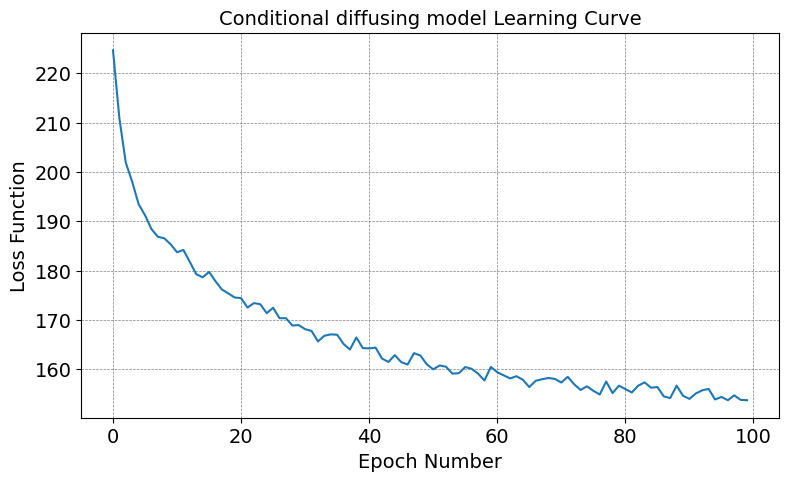

In [175]:
# diffusion learning curve
plt.figure(figsize=(9, 5))
plt.plot(diffusionFitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional diffusing model Learning Curve", size=14)
plt.grid(linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 14 (0.5 балла)
По аналогии с прошлым экспериментом с GAN моделью сгенерируйте выборку фейковых объектов равную размеру тестовой выборки и обучите градиентный бустинг. Обучите модель отличать реальные объекты от фейковых, после чего расчитайте метрики ROC-AUC и accuracy score. Какие получились результаты? Как вы их оцениваете? А в сравнении с GAN моделью?

ROC-AUC получился заметно хуже чем в Гане, стал 0.97. accuracy = 0.92. То есть в 92% бустинг говорит правильно фейк объект или реальный. Как я не старался менять гиперпараметры, мне не помогло. 

В общем резы фигня, генирация никуда не годиться. В гане лучше, ган еще можно юзать. 

In [221]:
X_fake_train = generate_with_diffusion(diffusionFitter.model, y_train, latent_dim, noise_scheduler)
X_fake_train = qt.inverse_transform(X_fake_train)
X_fake_test = generate_with_diffusion(diffusionFitter.model, y_test, latent_dim, noise_scheduler)
X_fake_test = qt.inverse_transform(X_fake_test)

In [222]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train_inv), axis=0)
XX_test = np.concatenate((X_fake_test, X_test_inv), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train_inv))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test_inv))

In [226]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]
yy_test_preds = clf.predict(XX_test)

In [229]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

acc = accuracy_score(yy_test, yy_test_preds)
print("accuracy = ", acc)

ROC AUC =  0.970332203303623
accuracy =  0.9260778128286015


## Отзыв

Поздравляю! Вы дошли до конца. Оставьте ваш отзыв ячейкой ниже или отправьте его в канал курса, нам будет очень интересно!

В целом норм дз. Не слишком просто, но и не слишком больно, умеренно больно. Думаю оно было полезное для меня, чтобы прям получше прочувствовать ганы и диффузионки. 

Благодарю весь преподавательский состав, надеюсь следующее дз будет не менее приятное и крутое